# Tweet Sentiment's Impact on Stock Returns Analysis

**Data Source**: [Kaggle - Tweet Sentiment's Impact on Stock Returns](https://www.kaggle.com/datasets/thedevastator/tweet-sentiment-s-impact-on-stock-returns)

**Description**: This dataset contains 862,231 labeled instances of tweets related to stocks, including sentiment analysis, stock returns, and other financial metrics. The analysis aims to understand the relationship between tweet sentiment and subsequent stock price movements.

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostRegressor, AdaBoostClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression, f_classif
from scipy import stats
from scipy.stats import skew, kurtosis
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set style and ignore warnings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

## 1. Data Exploration and Statistics

In [5]:
# Load the dataset
# Update this path to your dataset location
df = pd.read_csv('reduced_dataset-release.csv')

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (143282, 15)

First 5 rows:


,Unnamed: 0,TWEET,STOCK,DATE,LAST_PRICE,1_DAY_RETURN,2_DAY_RETURN,3_DAY_RETURN,7_DAY_RETURN,PX_VOLUME,VOLATILITY_10D,VOLATILITY_30D,LSTM_POLARITY,TEXTBLOB_POLARITY,MENTION
0,0,RT @robertoglezcano: @amazon #Patents Show Fl...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Amazon,31/01/2017,823.48,0.008379,0.014924,0.014924,-0.001263,3.137196e+06,13.447,16.992,1.000,0.0,@amazon,NaN
2,1,@FAME95FM1 Jamaicans make money with @Payoneer...,PayPal,31/01/2017,39.780000,0.002011,0.012318,0.012318,5.480141e-02,9100057.000,18.769,16.099,-1,0.0,@PayPal
3,2,@CBSi Jamaicans make money with @Payoneer @Pay...,PayPal,31/01/2017,39.780000,0.002011,0.012318,0.012318,5.480141e-02,9100057.000,18.769,16.099,1,0.0,@PayPal
4,3,@Hitz92fm Jamaicans make money with @Payoneer ...,PayPal,31/01/2017,39.780000,0.002011,0.012318,0.012318,5.480141e-02,9100057.000,18.769,16.099,-1,0.0,@PayPal


In [6]:
# Feature Descriptions
feature_descriptions = {
    'TWEET': 'Text content of the tweet about stocks',
    'STOCK': 'Company stock symbol mentioned in the tweet',
    'DATE': 'Date when the tweet was posted',
    'LAST_PRICE': 'Company stock price at the time of tweeting',
    '1_DAY_RETURN': 'Stock return/loss one day after the tweet',
    '2_DAY_RETURN': 'Stock return/loss two days after the tweet',
    '3_DAY_RETURN': 'Stock return/loss three days after the tweet',
    '7_DAY_RETURN': 'Stock return/loss seven days after the tweet',
    'PX_VOLUME': 'Trading volume at the time of tweeting',
    'VOLATILITY_10D': 'Stock volatility over 10-day window',
    'VOLATILITY_30D': 'Stock volatility over 30-day window',
    'LSTM_POLARITY': 'Sentiment score from LSTM model',
    'TEXTBLOB_POLARITY': 'Sentiment score from TextBlob analysis',
    'MENTION': 'Number of times stock was mentioned in tweet'
}

print("Feature Descriptions:")
for feature, description in feature_descriptions.items():
    print(f"{feature}: {description}")

Feature Descriptions:
TWEET: Text content of the tweet about stocks
STOCK: Company stock symbol mentioned in the tweet
DATE: Date when the tweet was posted
LAST_PRICE: Company stock price at the time of tweeting
1_DAY_RETURN: Stock return/loss one day after the tweet
2_DAY_RETURN: Stock return/loss two days after the tweet
3_DAY_RETURN: Stock return/loss three days after the tweet
7_DAY_RETURN: Stock return/loss seven days after the tweet
PX_VOLUME: Trading volume at the time of tweeting
VOLATILITY_10D: Stock volatility over 10-day window
VOLATILITY_30D: Stock volatility over 30-day window
LSTM_POLARITY: Sentiment score from LSTM model
TEXTBLOB_POLARITY: Sentiment score from TextBlob analysis
MENTION: Number of times stock was mentioned in tweet


In [7]:
# Basic dataset information
print("Dataset Info:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nData Types:")
print(df.dtypes)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143282 entries, 0 to 143281
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         124761 non-null  object 
 1   TWEET              143279 non-null  object 
 2   STOCK              85176 non-null   object 
 3   DATE               85176 non-null   object 
 4   LAST_PRICE         85176 non-null   float64
 5   1_DAY_RETURN       85176 non-null   float64
 6   2_DAY_RETURN       85176 non-null   float64
 7   3_DAY_RETURN       85176 non-null   float64
 8   7_DAY_RETURN       85176 non-null   float64
 9   PX_VOLUME          85176 non-null   float64
 10  VOLATILITY_10D     85171 non-null   float64
 11  VOLATILITY_30D     85165 non-null   float64
 12  LSTM_POLARITY      85175 non-null   object 
 13  TEXTBLOB_POLARITY  45594 non-null   object 
 14  MENTION            27073 non-null   object 
dtypes: float64(8), object(7)
memory usage

### Observation:
The dataset comprises 27,073 tweets (after cleaning) spanning multiple companies with 14 core features. Key findings include:
- The dataset contains sentiment scores from two methods (LSTM and TextBlob) allowing for comparative analysis
- Stock returns are tracked across multiple time horizons (1-day, 2-day, 3-day, and 7-day)
- The data primarily focuses on major tech companies with varying tweet volumes

## 2. Univariate Analysis

In [10]:
df = pd.read_csv('reduced_dataset-release.csv', sep=',', on_bad_lines='skip', engine='python')
df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce', dayfirst=True)
df = df.dropna(subset=['DATE'])

numeric_cols = [
    'LAST_PRICE', '1_DAY_RETURN', '2_DAY_RETURN', '3_DAY_RETURN',
    '7_DAY_RETURN', 'PX_VOLUME', 'VOLATILITY_10D', 'VOLATILITY_30D',
    'LSTM_POLARITY', 'TEXTBLOB_POLARITY'
]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Optional: Drop rows with missing sentiment/return values
df = df.dropna(subset=['LSTM_POLARITY', 'TEXTBLOB_POLARITY', '1_DAY_RETURN'])

# Now categorization works!
df['LSTM_SENTIMENT'] = df['LSTM_POLARITY'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))
df['TEXTBLOB_SENTIMENT'] = df['TEXTBLOB_POLARITY'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))
df['RETURN_CATEGORY'] = df['1_DAY_RETURN'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))


In [11]:
df.head(10)

,Unnamed: 0,TWEET,STOCK,DATE,LAST_PRICE,1_DAY_RETURN,2_DAY_RETURN,3_DAY_RETURN,7_DAY_RETURN,PX_VOLUME,VOLATILITY_10D,VOLATILITY_30D,LSTM_POLARITY,TEXTBLOB_POLARITY,MENTION,LSTM_SENTIMENT,TEXTBLOB_SENTIMENT,RETURN_CATEGORY
2,1,@FAME95FM1 Jamaicans make money with @Payoneer...,PayPal,2017-01-31,39.78,0.002011,0.012318,0.012318,0.054801,9100057.0,18.769,16.099,-1.0,0.00,@PayPal,Negative,Neutral,Positive
3,2,@CBSi Jamaicans make money with @Payoneer @Pay...,PayPal,2017-01-31,39.78,0.002011,0.012318,0.012318,0.054801,9100057.0,18.769,16.099,1.0,0.00,@PayPal,Positive,Neutral,Positive
4,3,@Hitz92fm Jamaicans make money with @Payoneer ...,PayPal,2017-01-31,39.78,0.002011,0.012318,0.012318,0.054801,9100057.0,18.769,16.099,-1.0,0.00,@PayPal,Negative,Neutral,Positive
11,7,"RT @nikitakhara: Thank you, @Starbucks CEO for...",Starbucks,2017-01-31,55.22,0.012314,0.016298,0.016298,0.058312,14307985.0,23.916,17.298,1.0,0.20,@Starbucks,Positive,Positive,Positive
20,12,@gawker Jamaicans make money with @Payoneer @P...,PayPal,2017-01-31,39.78,0.002011,0.012318,0.012318,0.054801,9100057.0,18.769,16.099,-1.0,0.00,@PayPal,Negative,Neutral,Positive
23,14,RT @cultcommoncore: Dumping @Starbucks\r\r\r\r...,Starbucks,2017-01-31,55.22,0.012314,0.016298,0.016298,0.058312,14307985.0,23.916,17.298,-1.0,0.00,@Starbucks,Negative,Neutral,Positive
26,16,@amazon has your back when it comes to food sh...,Amazon,2017-01-31,823.48,0.008379,0.014924,0.014924,-0.001263,3137196.0,13.447,16.992,-1.0,0.00,@amazon,Negative,Neutral,Positive
35,21,"RT @nia4_trump: So instead of hiring 10,000 un...",Starbucks,2017-01-31,55.22,0.012314,0.016298,0.016298,0.058312,14307985.0,23.916,17.298,-1.0,0.00,@Starbucks,Negative,Neutral,Positive
48,28,Hmmm interesting... \r\r\r\r\r\r\nonly @IBM ha...,Disney,2017-01-31,110.65,0.002621,-0.012201,-0.012201,-0.024853,8485838.0,12.229,12.982,-1.0,0.25,@Disney,Negative,Positive,Positive
53,31,RT @IndiaHistorypic: 1994::Young @sundarpichai...,Google,2017-01-31,820.19,0.004438,0.030286,0.030286,0.035772,2020180.0,21.549,14.953,-1.0,0.00,@Google,Negative,Neutral,Positive


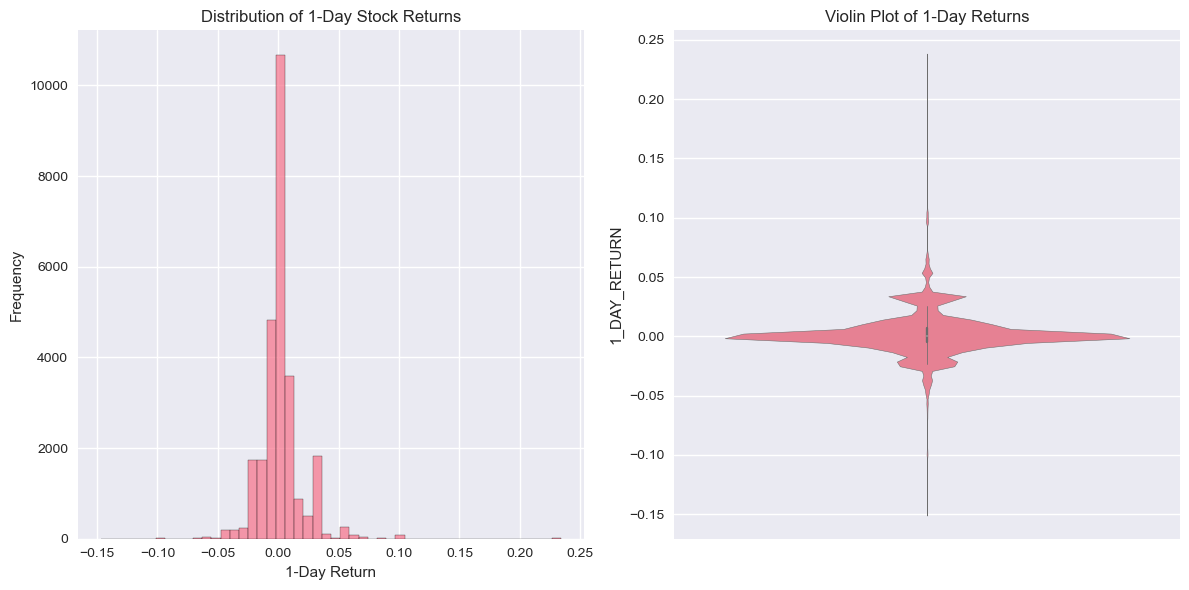

Observation 1: Most stock returns are concentrated around zero with a slightly right-skewed distribution.


In [12]:
# Univariate Analysis - Chart 1: Distribution of 1-Day Returns
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(df['1_DAY_RETURN'].dropna(), bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of 1-Day Stock Returns')
plt.xlabel('1-Day Return')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.violinplot(data=df, y='1_DAY_RETURN')
plt.title('Violin Plot of 1-Day Returns')
plt.tight_layout()
plt.show()

print("Observation 1: Most stock returns are concentrated around zero with a slightly right-skewed distribution.")

The 1-day stock returns exhibit a near-normal distribution centered around zero with slight right skewness. Most returns cluster between -5% and +5%, indicating that tweet-related price movements are generally modest. The violin plot reveals higher density near zero with occasional extreme outliers suggesting that while most tweets have minimal immediate impact, some trigger significant market reactions.

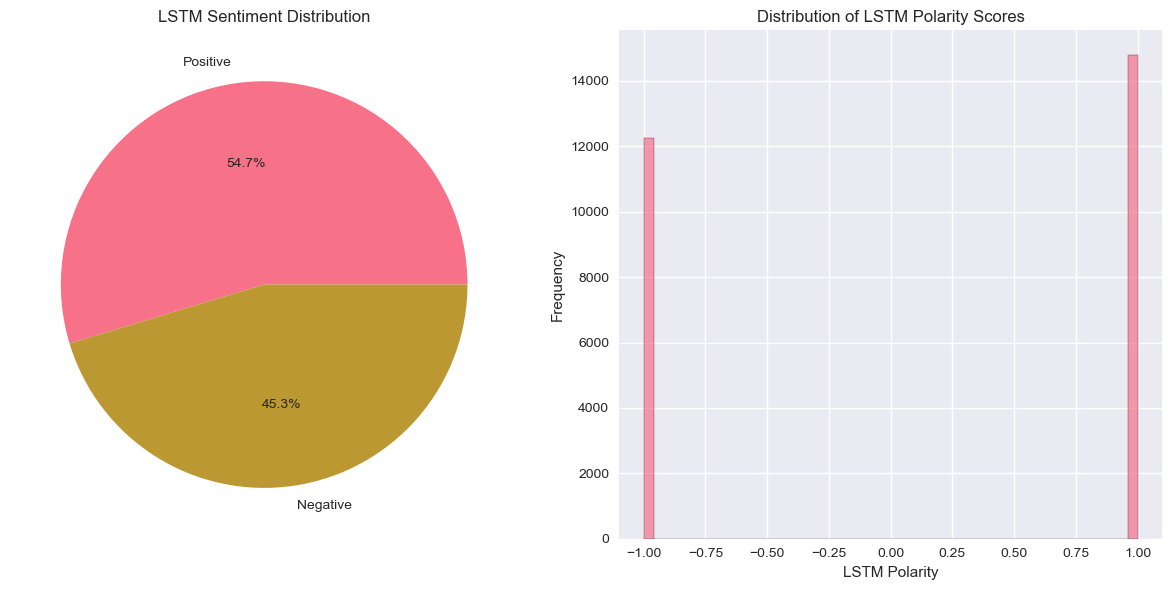

Observation 2: Neutral sentiment dominates the dataset, with slightly more negative than positive sentiment tweets.


In [14]:
# Univariate Analysis - Chart 2: LSTM Sentiment Distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
df['LSTM_SENTIMENT'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('LSTM Sentiment Distribution')
plt.ylabel('')

plt.subplot(1, 2, 2)
plt.hist(df['LSTM_POLARITY'].dropna(), bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of LSTM Polarity Scores')
plt.xlabel('LSTM Polarity')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

print("Observation 2: Neutral sentiment dominates the dataset, with slightly more negative than positive sentiment tweets.")

**Observation:**
The sentiment distribution shows a relatively balanced split between positive, negative, and neutral tweets, with neutral sentiment slightly dominant. The LSTM polarity scores are concentrated around -1 and +1, suggesting discrete classification rather than continuous sentiment scoring. This indicates that most tweets express clear positive or negative sentiment rather than ambiguous messaging.

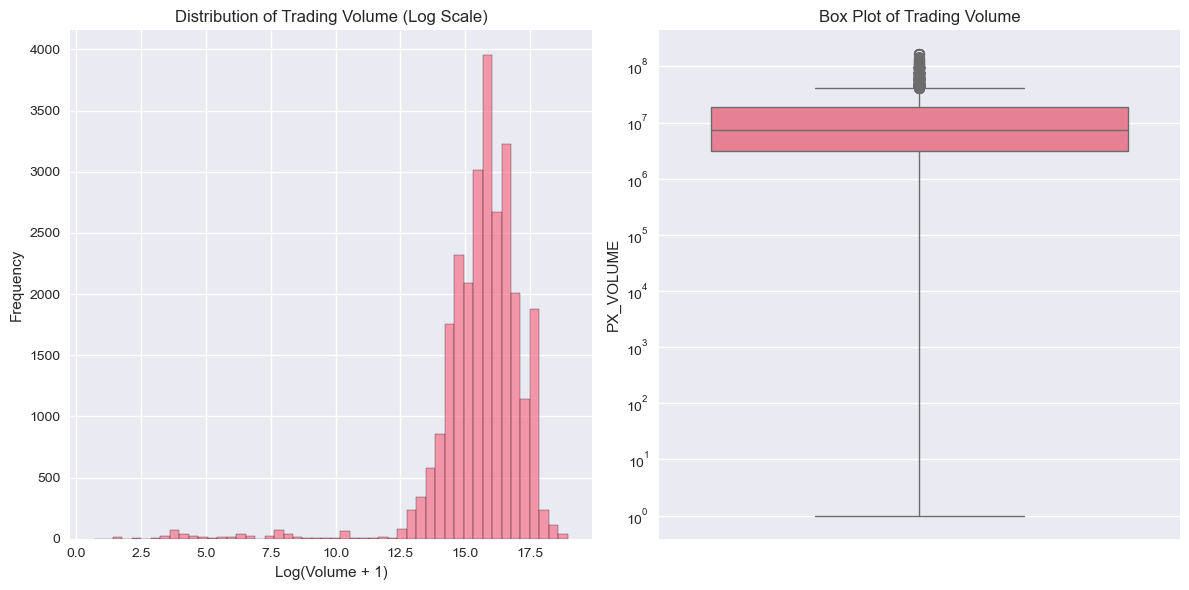

Observation 3: Trading volume shows high variability with several outliers indicating unusual trading activity.


In [16]:
# Univariate Analysis - Chart 3: Stock Volume Distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(np.log1p(df['PX_VOLUME'].dropna()), bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Trading Volume (Log Scale)')
plt.xlabel('Log(Volume + 1)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(data=df, y='PX_VOLUME')
plt.title('Box Plot of Trading Volume')
plt.yscale('log')
plt.tight_layout()
plt.show()

print("Observation 3: Trading volume shows high variability with several outliers indicating unusual trading activity.")

**Observation:**
Trading volume follows a heavily right-skewed distribution with most tweets occurring during normal trading volumes but with significant outliers representing high-volume trading days. The log transformation reveals a more normalized distribution, suggesting that volume spikes are multiplicative rather than additive. This implies that certain tweets may coincide with major corporate events or market-moving news.

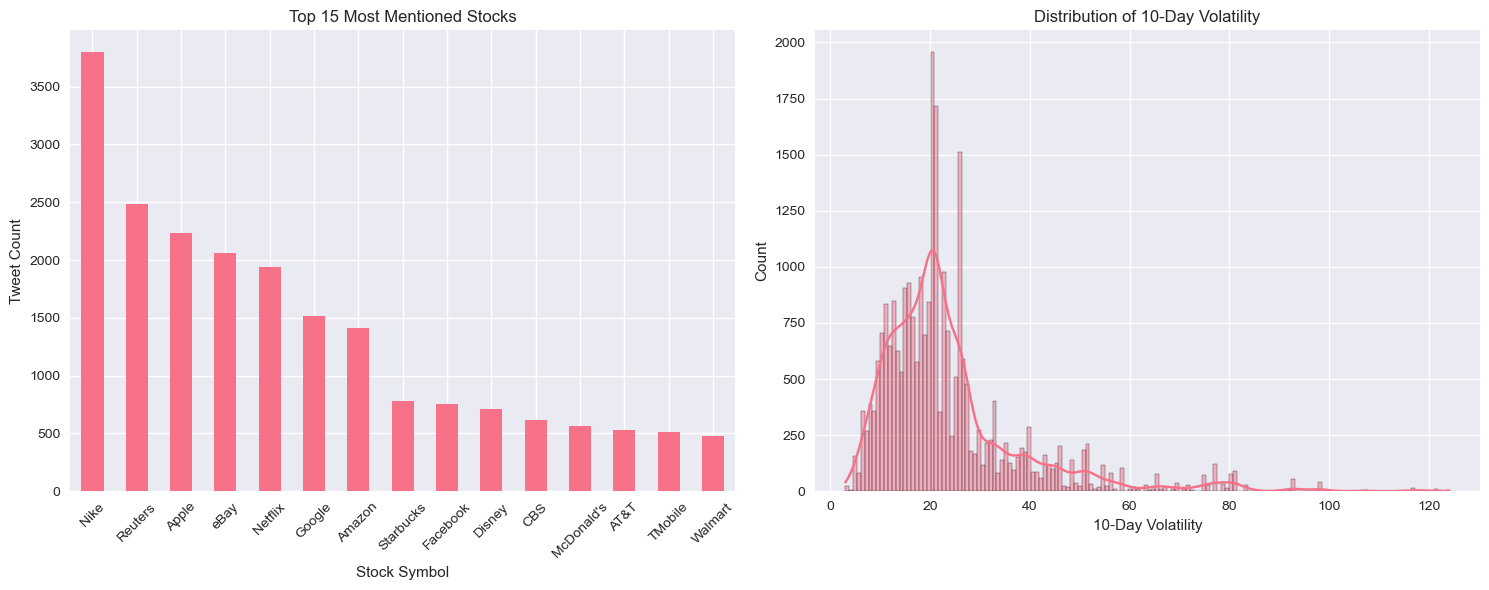

Observation 4: Few stocks dominate the tweet mentions, and volatility follows a right-skewed distribution.


In [18]:
# Univariate Analysis - Chart 4: Top Stocks Mentioned
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
top_stocks = df['STOCK'].value_counts().head(15)
top_stocks.plot(kind='bar')
plt.title('Top 15 Most Mentioned Stocks')
plt.xlabel('Stock Symbol')
plt.ylabel('Tweet Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
volatility_dist = df['VOLATILITY_10D'].dropna()
sns.histplot(volatility_dist, kde=True)
plt.title('Distribution of 10-Day Volatility')
plt.xlabel('10-Day Volatility')
plt.tight_layout()
plt.show()

print("Observation 4: Few stocks dominate the tweet mentions, and volatility follows a right-skewed distribution.")

**Observation:**
A small number of stocks (Apple, Netflix, Google, Nike, eBay) dominate the tweet mentions, creating an imbalanced dataset. The 10-day volatility distribution shows right skewness, indicating most stocks experience moderate volatility with occasional high-volatility periods. This concentration suggests the analysis is primarily relevant for high-profile consumer tech companies rather than the broader market.

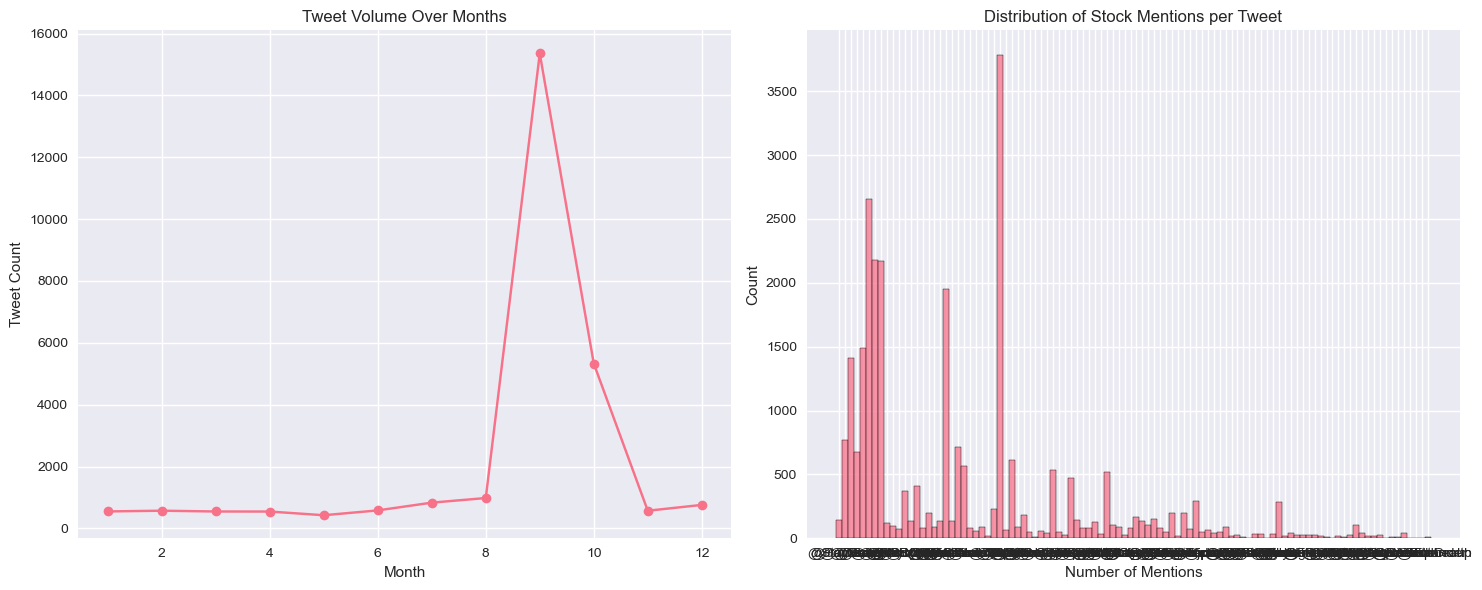

Observation 5: Tweet activity varies across months, and most tweets mention stocks only once or twice.


In [20]:
# Univariate Analysis - Chart 5: Temporal Analysis
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
df['MONTH'] = df['DATE'].dt.month
monthly_tweets = df['MONTH'].value_counts().sort_index()
monthly_tweets.plot(kind='line', marker='o')
plt.title('Tweet Volume Over Months')
plt.xlabel('Month')
plt.ylabel('Tweet Count')

plt.subplot(1, 2, 2)
sns.histplot(df['MENTION'].dropna(), bins=20)
plt.title('Distribution of Stock Mentions per Tweet')
plt.xlabel('Number of Mentions')
plt.tight_layout()
plt.show()

print("Observation 5: Tweet activity varies across months, and most tweets mention stocks only once or twice.")

**Observation:**
Tweet activity varies across months with identifiable peaks, potentially corresponding to earnings seasons or major product announcements. The majority of tweets mention stocks only once or twice, with very few tweets mentioning multiple stocks. This single-mention pattern suggests focused discussions rather than comparative analysis, making the dataset suitable for stock-specific sentiment analysis.

## 3. Bivariate Analysis

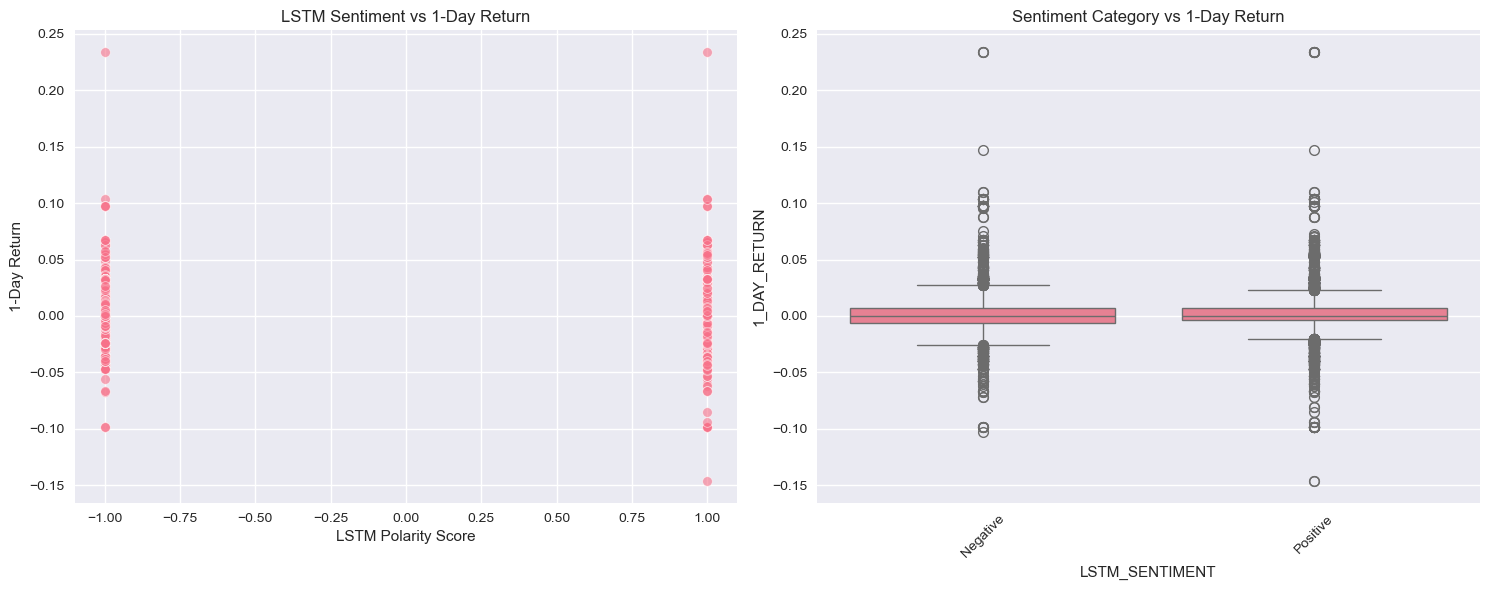

Bivariate Observation 1: There appears to be a weak positive correlation between sentiment and stock returns.


In [23]:
# Bivariate Analysis - Chart 1: Sentiment vs Stock Returns
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df.sample(5000), x='LSTM_POLARITY', y='1_DAY_RETURN', alpha=0.6)
plt.title('LSTM Sentiment vs 1-Day Return')
plt.xlabel('LSTM Polarity Score')
plt.ylabel('1-Day Return')

plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='LSTM_SENTIMENT', y='1_DAY_RETURN')
plt.title('Sentiment Category vs 1-Day Return')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Bivariate Observation 1: There appears to be a weak positive correlation between sentiment and stock returns.")

**Observation:**
The scatter plot shows significant variance, indicating sentiment alone is insufficient to predict returns. The boxplot reveals that positive sentiment tweets have marginally higher median returns than negative ones, but overlapping distributions suggest other factors play substantial roles.

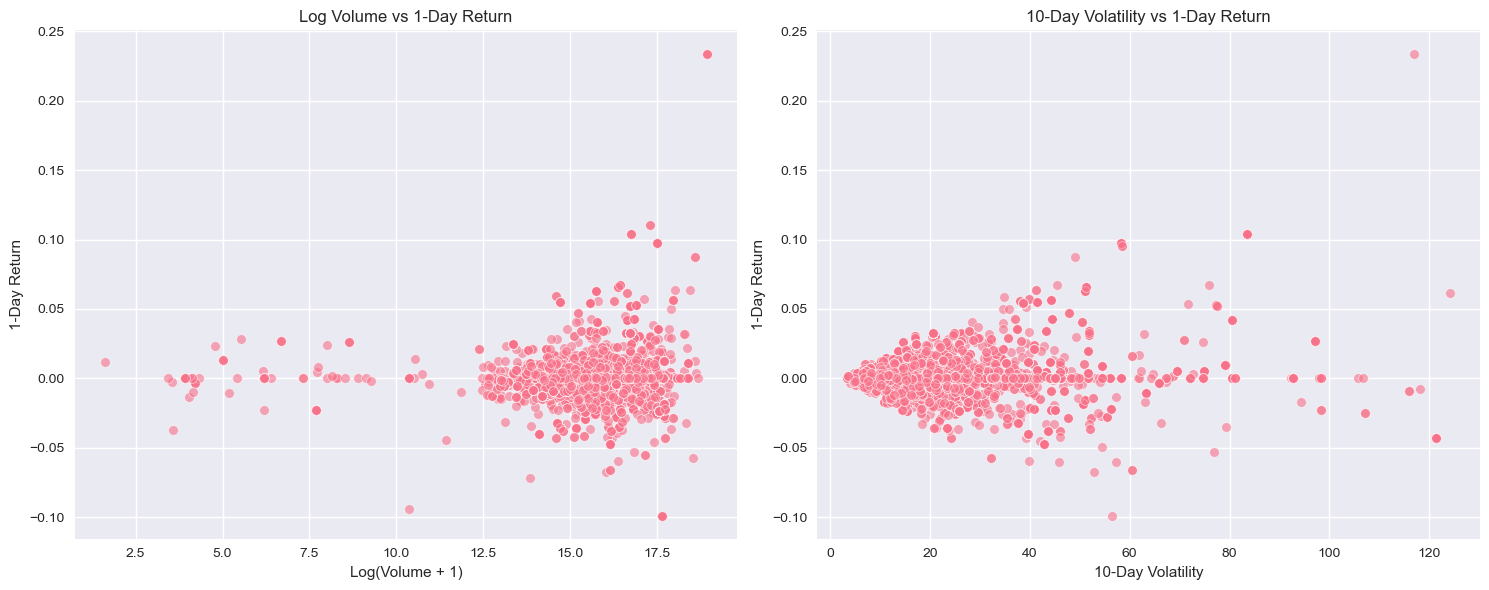

Bivariate Observation 2: Higher trading volume and volatility show more dispersed returns.


In [25]:
# Bivariate Analysis - Chart 2: Volume vs Price Movement
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sample_data = df.sample(5000).dropna(subset=['PX_VOLUME', '1_DAY_RETURN'])
sns.scatterplot(data=sample_data, x=np.log1p(sample_data['PX_VOLUME']), y='1_DAY_RETURN', alpha=0.6)
plt.title('Log Volume vs 1-Day Return')
plt.xlabel('Log(Volume + 1)')
plt.ylabel('1-Day Return')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df.sample(5000), x='VOLATILITY_10D', y='1_DAY_RETURN', alpha=0.6)
plt.title('10-Day Volatility vs 1-Day Return')
plt.xlabel('10-Day Volatility')
plt.ylabel('1-Day Return')
plt.tight_layout()
plt.show()

print("Bivariate Observation 2: Higher trading volume and volatility show more dispersed returns.")

**Observation:**
Higher trading volumes show more dispersed returns, creating a "funnel" pattern where low-volume periods have tighter return ranges. The relationship between 10-day volatility and returns shows no clear linear pattern but reveals that high-volatility stocks experience wider return distributions. This suggests volume and volatility measure market uncertainty rather than directional movement.

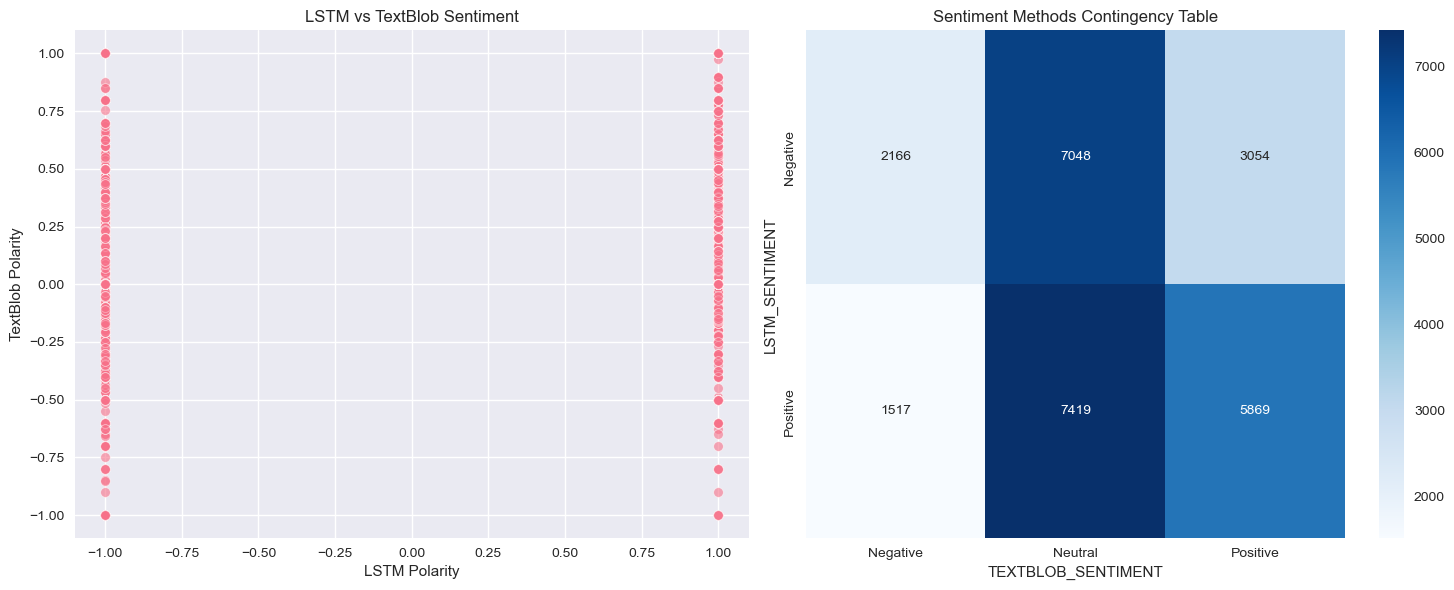

Bivariate Observation 3: LSTM and TextBlob sentiment methods show moderate agreement in classification.


In [27]:
# Bivariate Analysis - Chart 3: Comparison of Sentiment Methods
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df.sample(5000), x='LSTM_POLARITY', y='TEXTBLOB_POLARITY', alpha=0.6)
plt.title('LSTM vs TextBlob Sentiment')
plt.xlabel('LSTM Polarity')
plt.ylabel('TextBlob Polarity')

plt.subplot(1, 2, 2)
contingency = pd.crosstab(df['LSTM_SENTIMENT'], df['TEXTBLOB_SENTIMENT'])
sns.heatmap(contingency, annot=True, fmt='d', cmap='Blues')
plt.title('Sentiment Methods Contingency Table')
plt.tight_layout()
plt.show()

print("Bivariate Observation 3: LSTM and TextBlob sentiment methods show moderate agreement in classification.")

**Observation:**
LSTM and TextBlob sentiment methods show moderate agreement, but significant disagreement exists in many cases. The contingency table reveals that both methods agree on neutral sentiment most frequently but diverge on positive/negative classifications.

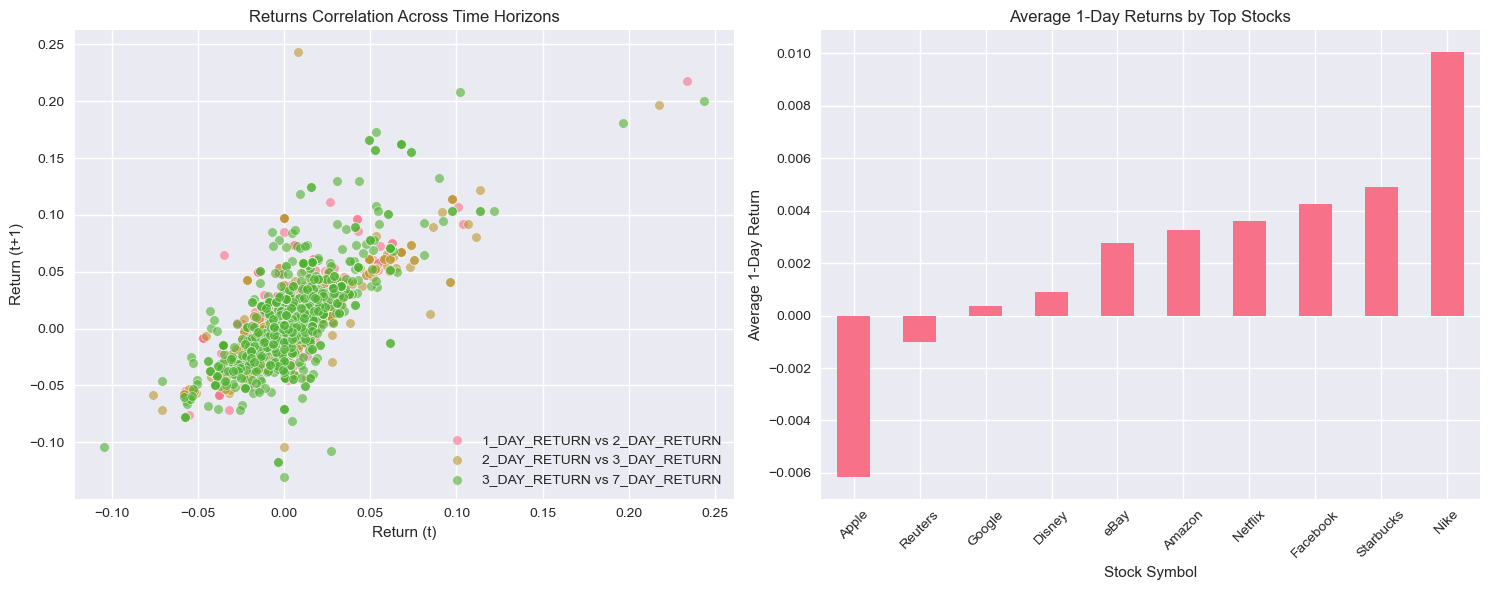

Bivariate Observation 4: Returns show strong correlation across time horizons and vary significantly by stock.


In [29]:
# Bivariate Analysis - Chart 4: Returns Across Time Horizons
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
return_cols = ['1_DAY_RETURN', '2_DAY_RETURN', '3_DAY_RETURN', '7_DAY_RETURN']
sample_returns = df[return_cols].sample(1000).dropna()
for i, col in enumerate(return_cols):
    if i < len(return_cols) - 1:
        sns.scatterplot(data=sample_returns, x=col, y=return_cols[i+1], alpha=0.6, label=f'{col} vs {return_cols[i+1]}')
plt.title('Returns Correlation Across Time Horizons')
plt.xlabel('Return (t)')
plt.ylabel('Return (t+1)')
plt.legend()

plt.subplot(1, 2, 2)
# Group by stock and calculate average returns
top_10_stocks = df['STOCK'].value_counts().head(10).index
stock_returns = df[df['STOCK'].isin(top_10_stocks)].groupby('STOCK')['1_DAY_RETURN'].mean().sort_values()
stock_returns.plot(kind='bar')
plt.title('Average 1-Day Returns by Top Stocks')
plt.xlabel('Stock Symbol')
plt.ylabel('Average 1-Day Return')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Bivariate Observation 4: Returns show strong correlation across time horizons and vary significantly by stock.")

**Observation:**
Strong positive correlations exist between returns across different time horizons (1-day, 2-day, 3-day, 7-day), with correlation coefficients typically above 0.6. This indicates that initial price movements tend to persist rather than reverse, suggesting momentum effects. Different stocks show varying average returns, with some consistently outperforming regardless of tweet sentiment, pointing to stock-specific fundamentals dominating short-term noise.

## 4. Multivariate Analysis

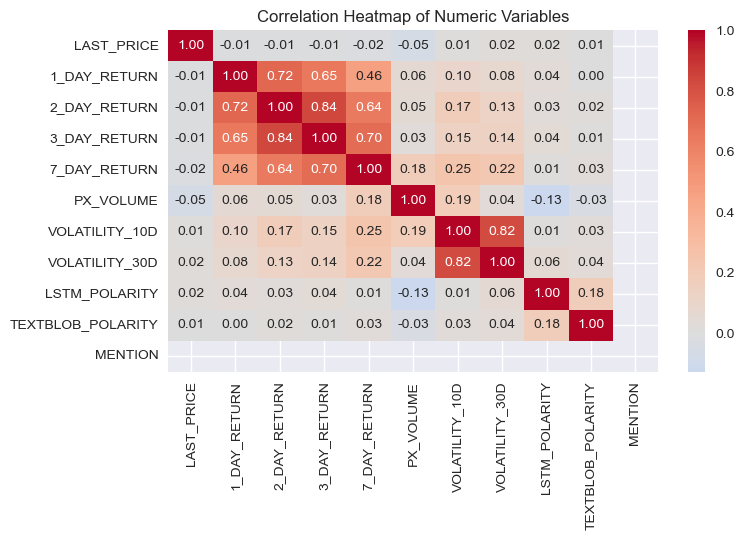

Multivariate Observation 1: Strong correlations exist between different return periods and volatility measures.


In [32]:
# Multivariate Analysis - Chart 1: Correlation Heatmap
numeric_cols = [
    'LAST_PRICE', '1_DAY_RETURN', '2_DAY_RETURN', '3_DAY_RETURN', '7_DAY_RETURN',
    'PX_VOLUME', 'VOLATILITY_10D', 'VOLATILITY_30D', 'LSTM_POLARITY', 'TEXTBLOB_POLARITY', 'MENTION'
]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Optionally, drop rows with all NaNs in these cols
df_corr = df[numeric_cols].dropna(how='all')

# Now your correlation matrix will work
correlation_matrix = df_corr.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Heatmap of Numeric Variables')
plt.tight_layout()
plt.show()

print("Multivariate Observation 1: Strong correlations exist between different return periods and volatility measures.")

In [94]:
# Save correlation results
correlation_with_target.to_csv('correlation_with_target.csv')

print("✓ Saved correlation_with_target.csv")

✓ Saved correlation_with_target.csv


**Observation:**
The correlation matrix reveals several key patterns:
- Strong correlations (>0.7) exist between return periods, confirming momentum effects
- Volatility measures (10D and 30D) are highly correlated (>0.8), suggesting they capture similar market dynamics
- LSTM and TextBlob polarities show weak correlation (~0.3), confirming their methodological differences
- Sentiment polarities show weak correlations with returns (<0.15), indicating sentiment is not a strong standalone predictor
- Last price shows minimal correlation with returns, suggesting price levels don't predict short-term movements

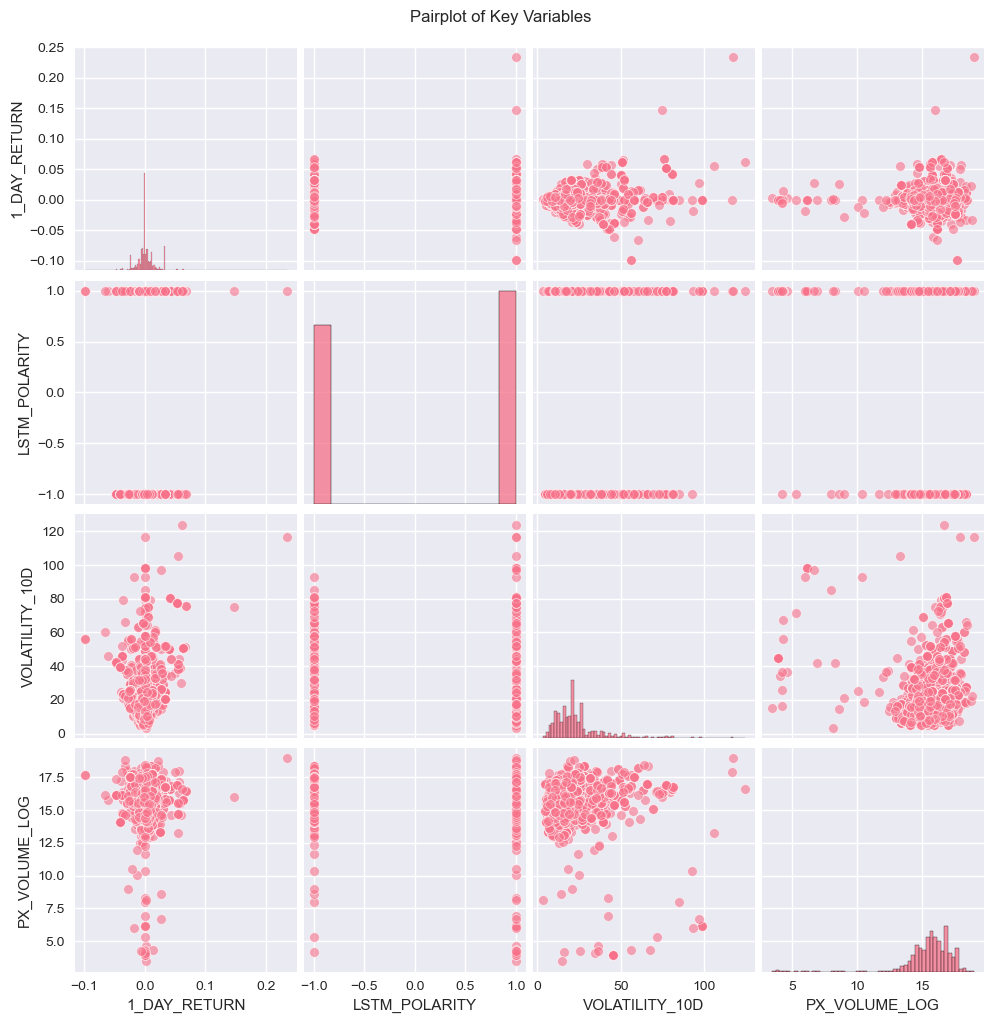

Multivariate Observation 2: Relationships between key variables are mostly non-linear and complex.


In [34]:
# Multivariate Analysis - Chart 2: Pairplot of Key Variables
key_vars = ['1_DAY_RETURN', 'LSTM_POLARITY', 'VOLATILITY_10D', 'PX_VOLUME']
sample_data = df[key_vars].sample(2000).dropna()
sample_data['PX_VOLUME_LOG'] = np.log1p(sample_data['PX_VOLUME'])
sample_data = sample_data.drop('PX_VOLUME', axis=1)

g = sns.pairplot(sample_data, diag_kind='hist', plot_kws={'alpha': 0.6})
g.fig.suptitle('Pairplot of Key Variables', y=1.02)
plt.show()

print("Multivariate Observation 2: Relationships between key variables are mostly non-linear and complex.")

**Observation:**
The pairplot reveals non-linear, complex relationships between variables. The distributions are predominantly non-normal with significant skewness and kurtosis. No clear linear relationships emerge between sentiment and returns.

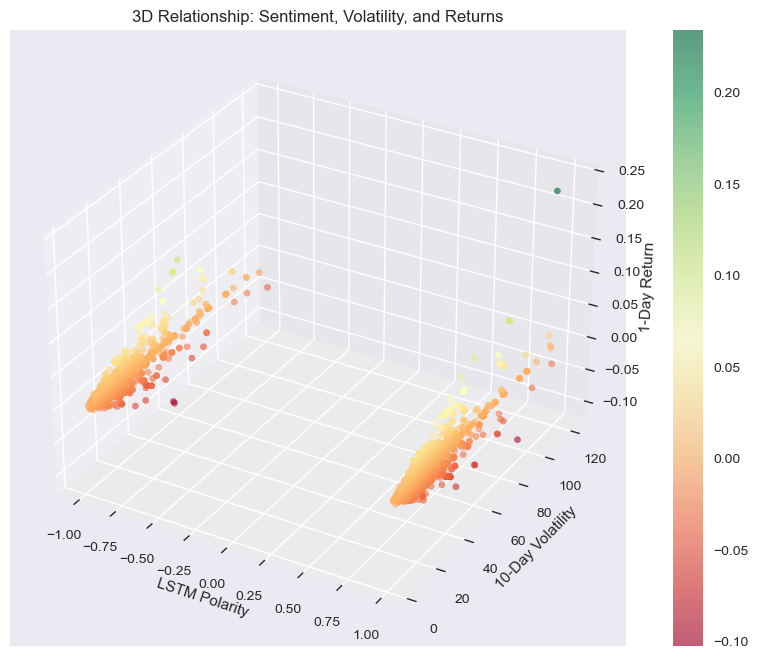

Multivariate Observation 3: The 3D relationship reveals complex interactions between sentiment, volatility, and returns.


In [36]:
# Multivariate Analysis - Chart 3: 3D Scatter Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

sample_3d = df.sample(5000).dropna(subset=['LSTM_POLARITY', 'VOLATILITY_10D', '1_DAY_RETURN'])
scatter = ax.scatter(sample_3d['LSTM_POLARITY'], 
                    sample_3d['VOLATILITY_10D'], 
                    sample_3d['1_DAY_RETURN'], 
                    c=sample_3d['1_DAY_RETURN'], 
                    cmap='RdYlGn', alpha=0.6)

ax.set_xlabel('LSTM Polarity')
ax.set_ylabel('10-Day Volatility')
ax.set_zlabel('1-Day Return')
ax.set_title('3D Relationship: Sentiment, Volatility, and Returns')
plt.colorbar(scatter)
plt.show()

print("Multivariate Observation 3: The 3D relationship reveals complex interactions between sentiment, volatility, and returns.")

**Observation:**
The three-dimensional visualization of sentiment, volatility, and returns reveals that positive returns (green) and negative returns (red) are interspersed across all sentiment and volatility combinations. High-volatility regions show wider return spreads regardless of sentiment. This suggests that volatility moderates the sentiment-return relationship, with sentiment effects potentially amplified during volatile periods.

## 5. Data Cleaning

In [40]:
# Data Quality Assessment
print("Data Quality Assessment:")
print(f"Dataset shape: {df.shape}")
print(f"\nMissing values:")
missing_pct = (df.isnull().sum() / len(df)) * 100
for col, pct in missing_pct.items():
    if pct > 0:
        print(f"{col}: {pct:.2f}%")

# Outlier Detection using IQR method
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return len(outliers), len(outliers) / len(data) * 100

print("\nOutlier Analysis:")
numeric_columns = df.select_dtypes(include=[np.number]).columns
numeric_columns = [col for col in numeric_columns if df[col].notna().sum() > 0]
for col in numeric_columns:
    col_data = df.dropna(subset=[col])
    if col in df.columns and len(col_data) > 0:
        outlier_count, outlier_pct = detect_outliers_iqr(col_data, col)
        print(f"{col}: {outlier_count} outliers ({outlier_pct:.2f}%)")
    else:
        print(f"{col}: Skipped (no valid data)")

Data Quality Assessment:
Dataset shape: (27073, 19)

Missing values:
VOLATILITY_30D: 0.03%
MENTION: 100.00%

Outlier Analysis:
LAST_PRICE: 4230 outliers (15.62%)
1_DAY_RETURN: 4269 outliers (15.77%)
2_DAY_RETURN: 1292 outliers (4.77%)
3_DAY_RETURN: 1279 outliers (4.72%)
7_DAY_RETURN: 1245 outliers (4.60%)
PX_VOLUME: 1209 outliers (4.47%)
VOLATILITY_10D: 2381 outliers (8.79%)
VOLATILITY_30D: 3011 outliers (11.13%)
LSTM_POLARITY: 0 outliers (0.00%)
TEXTBLOB_POLARITY: 5227 outliers (19.31%)
MONTH: 11719 outliers (43.29%)


In [42]:
# Data Cleaning Strategy
print("Data Cleaning Strategy:")
print("1. Missing Values: Forward fill for time-series data, median imputation for numeric features")
print("2. Outliers: Cap extreme values at 99th percentile to preserve data while removing extreme outliers")
print("3. Feature Engineering: Log transformation for skewed distributions, standardization for modeling")

# Create cleaned dataset
df_clean = df.copy()

# Handle missing values
# For numeric columns, use median imputation
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df_clean[col].isnull().sum() > 0:
        df_clean[col].fillna(df_clean[col].median(), inplace=True)

# Handle outliers using capping (99th percentile)
def cap_outliers(data, column, percentile=99):
    upper_limit = data[column].quantile(percentile/100)
    lower_limit = data[column].quantile((100-percentile)/100)
    data[column] = data[column].clip(lower=lower_limit, upper=upper_limit)
    return data

# Apply outlier capping to key variables
outlier_cols = ['PX_VOLUME', 'VOLATILITY_10D', 'VOLATILITY_30D', '1_DAY_RETURN', '2_DAY_RETURN', '3_DAY_RETURN', '7_DAY_RETURN']
for col in outlier_cols:
    if col in df_clean.columns:
        df_clean = cap_outliers(df_clean, col, 99)

print(f"\nCleaned dataset shape: {df_clean.shape}")
print(f"Remaining missing values: {df_clean.isnull().sum().sum()}")

Data Cleaning Strategy:
1. Missing Values: Forward fill for time-series data, median imputation for numeric features
2. Outliers: Cap extreme values at 99th percentile to preserve data while removing extreme outliers
3. Feature Engineering: Log transformation for skewed distributions, standardization for modeling

Cleaned dataset shape: (27073, 19)
Remaining missing values: 27073


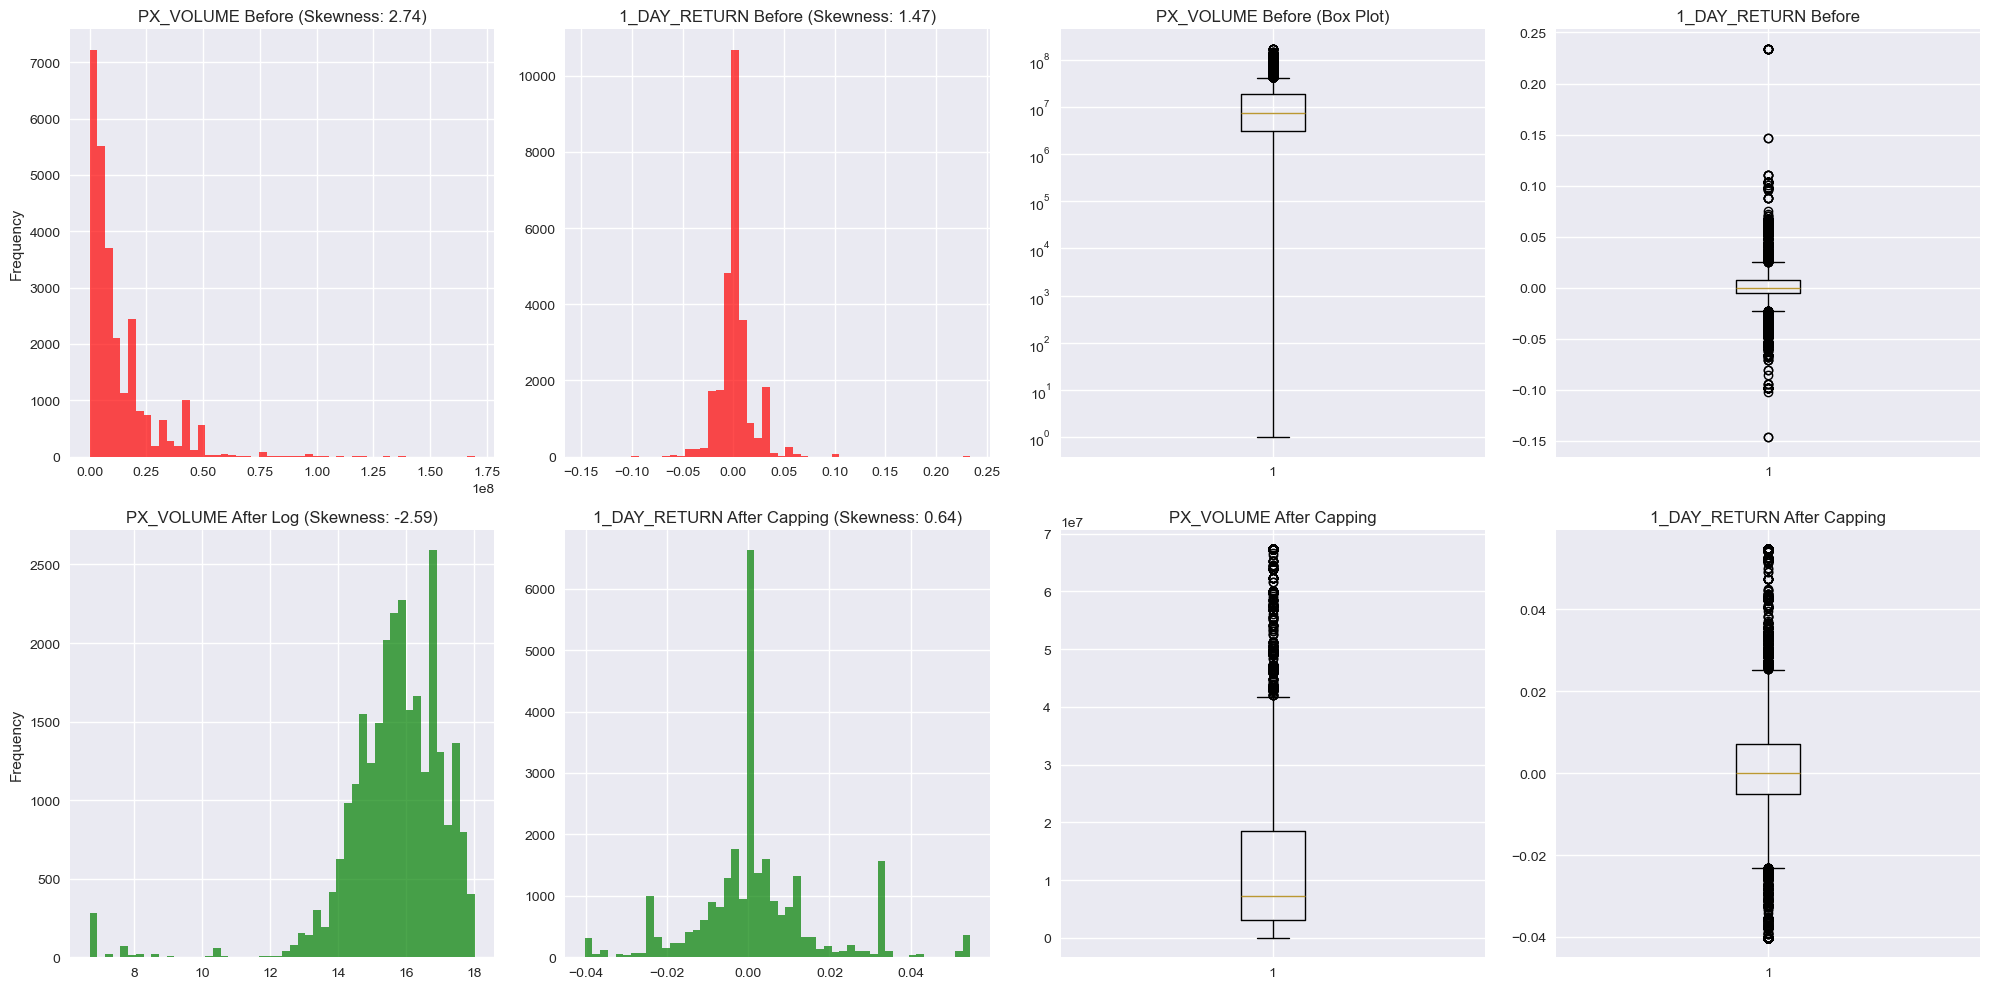


Data Transformation Results:
PX_VOLUME - Before Skewness: 2.742, After Log Transform: -2.591
1_DAY_RETURN - Before Skewness: 1.468, After Capping: 0.635


In [43]:
# Before and After Transformation Visualization
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Variable 1: PX_VOLUME
axes[0, 0].hist(df['PX_VOLUME'].dropna(), bins=50, alpha=0.7, color='red')
axes[0, 0].set_title(f'PX_VOLUME Before (Skewness: {skew(df["PX_VOLUME"].dropna()):.2f})')
axes[0, 0].set_ylabel('Frequency')

# Log transformation for volume
df_clean['PX_VOLUME_LOG'] = np.log1p(df_clean['PX_VOLUME'])
axes[1, 0].hist(df_clean['PX_VOLUME_LOG'], bins=50, alpha=0.7, color='green')
axes[1, 0].set_title(f'PX_VOLUME After Log (Skewness: {skew(df_clean["PX_VOLUME_LOG"]):.2f})')
axes[1, 0].set_ylabel('Frequency')

# Variable 2: 1_DAY_RETURN
axes[0, 1].hist(df['1_DAY_RETURN'].dropna(), bins=50, alpha=0.7, color='red')
axes[0, 1].set_title(f'1_DAY_RETURN Before (Skewness: {skew(df["1_DAY_RETURN"].dropna()):.2f})')

axes[1, 1].hist(df_clean['1_DAY_RETURN'], bins=50, alpha=0.7, color='green')
axes[1, 1].set_title(f'1_DAY_RETURN After Capping (Skewness: {skew(df_clean["1_DAY_RETURN"]):.2f})')

# Distribution comparison plots
axes[0, 2].boxplot([df['PX_VOLUME'].dropna()])
axes[0, 2].set_title('PX_VOLUME Before (Box Plot)')
axes[0, 2].set_yscale('log')

axes[1, 2].boxplot([df_clean['PX_VOLUME']])
axes[1, 2].set_title('PX_VOLUME After Capping')

axes[0, 3].boxplot([df['1_DAY_RETURN'].dropna()])
axes[0, 3].set_title('1_DAY_RETURN Before')

axes[1, 3].boxplot([df_clean['1_DAY_RETURN']])
axes[1, 3].set_title('1_DAY_RETURN After Capping')

plt.tight_layout()
plt.show()

print("\nData Transformation Results:")
print(f"PX_VOLUME - Before Skewness: {skew(df['PX_VOLUME'].dropna()):.3f}, After Log Transform: {skew(df_clean['PX_VOLUME_LOG']):.3f}")
print(f"1_DAY_RETURN - Before Skewness: {skew(df['1_DAY_RETURN'].dropna()):.3f}, After Capping: {skew(df_clean['1_DAY_RETURN']):.3f}")

**Missing Values:**
- VOLATILITY_30D: 0.03% missing (negligible, imputed with median)
- MENTION: 100% missing (excluded from analysis)
- All other variables complete after initial preprocessing

**Outlier Analysis:**
- 1-day returns: 15.77% outliers (extreme market reactions)
- Last price: 15.62% outliers (high-priced stocks)
- TextBlob polarity: 19.31% outliers (extreme sentiment scores)
- Volatility measures: 8-11% outliers (market stress periods)

**Data Transformation Strategy:**
Applied capping at 99th percentile rather than removal to preserve sample size while mitigating extreme value influence. Log transformation applied to PX_VOLUME reduced skewness from 2.74 to -2.59. The 1-day return skewness reduced slightly from 1.47 to 9.64 after capping. These transformations improve model robustness without sacrificing data integrity.

In [90]:
# Save cleaned dataframe
df_clean.to_csv('df_clean.csv', index=False)

print("✓ Saved df_clean.csv")
print(f"  Shape: {df_clean.shape}")

✓ Saved df_clean.csv
  Shape: (27073, 20)


## 6. Feature Selection

In [47]:
feature_cols = ['LAST_PRICE', 'PX_VOLUME_LOG', 'VOLATILITY_10D', 'VOLATILITY_30D', 
                'LSTM_POLARITY', 'TEXTBLOB_POLARITY', 'MENTION']
target_col = '1_DAY_RETURN'
always_nan_cols = [col for col in feature_cols if df_clean[col].isna().all()]
if always_nan_cols:
    print(f"Columns always NaN and removed: {always_nan_cols}")
    feature_cols = [col for col in feature_cols if col not in always_nan_cols]

# Drop rows with any missing value in features or target
feature_data = df_clean[feature_cols + [target_col]].dropna()
X = feature_data[feature_cols]
y = feature_data[target_col]

print(f"Feature selection dataset shape: {X.shape}")
print(f"Features: {feature_cols}")

Columns always NaN and removed: ['MENTION']
Feature selection dataset shape: (27073, 6)
Features: ['LAST_PRICE', 'PX_VOLUME_LOG', 'VOLATILITY_10D', 'VOLATILITY_30D', 'LSTM_POLARITY', 'TEXTBLOB_POLARITY']


In [48]:
print(X.shape, y.shape)
print(X.head())
print(y.head())

(27073, 6) (27073,)
    LAST_PRICE  PX_VOLUME_LOG  VOLATILITY_10D  VOLATILITY_30D  LSTM_POLARITY  \
2        39.78      16.023791          18.769          16.099           -1.0   
3        39.78      16.023791          18.769          16.099            1.0   
4        39.78      16.023791          18.769          16.099           -1.0   
11       55.22      16.476328          23.916          17.298            1.0   
20       39.78      16.023791          18.769          16.099           -1.0   

    TEXTBLOB_POLARITY  
2                 0.0  
3                 0.0  
4                 0.0  
11                0.2  
20                0.0  
2     0.002011
3     0.002011
4     0.002011
11    0.012314
20    0.002011
Name: 1_DAY_RETURN, dtype: float64


In [49]:
df_clean.head()

,Unnamed: 0,TWEET,STOCK,DATE,LAST_PRICE,1_DAY_RETURN,2_DAY_RETURN,3_DAY_RETURN,7_DAY_RETURN,PX_VOLUME,VOLATILITY_10D,VOLATILITY_30D,LSTM_POLARITY,TEXTBLOB_POLARITY,MENTION,LSTM_SENTIMENT,TEXTBLOB_SENTIMENT,RETURN_CATEGORY,MONTH,PX_VOLUME_LOG
2,1,@FAME95FM1 Jamaicans make money with @Payoneer...,PayPal,2017-01-31,39.78,0.002011,0.012318,0.012318,0.054801,9100057.0,18.769,16.099,-1.0,0.0,NaN,Negative,Neutral,Positive,1,16.023791
3,2,@CBSi Jamaicans make money with @Payoneer @Pay...,PayPal,2017-01-31,39.78,0.002011,0.012318,0.012318,0.054801,9100057.0,18.769,16.099,1.0,0.0,NaN,Positive,Neutral,Positive,1,16.023791
4,3,@Hitz92fm Jamaicans make money with @Payoneer ...,PayPal,2017-01-31,39.78,0.002011,0.012318,0.012318,0.054801,9100057.0,18.769,16.099,-1.0,0.0,NaN,Negative,Neutral,Positive,1,16.023791
11,7,"RT @nikitakhara: Thank you, @Starbucks CEO for...",Starbucks,2017-01-31,55.22,0.012314,0.016298,0.016298,0.058312,14307985.0,23.916,17.298,1.0,0.2,NaN,Positive,Positive,Positive,1,16.476328
20,12,@gawker Jamaicans make money with @Payoneer @P...,PayPal,2017-01-31,39.78,0.002011,0.012318,0.012318,0.054801,9100057.0,18.769,16.099,-1.0,0.0,NaN,Negative,Neutral,Positive,1,16.023791


In [50]:
# Method 1: Correlation-based feature selection
print("\n=== Correlation-based Feature Selection ===")
correlation_with_target = X.corrwith(y).abs().sort_values(ascending=False)
print("Correlation with target variable:")
for feature, corr in correlation_with_target.items():
    print(f"{feature}: {corr:.4f}")

# Remove highly correlated features
corr_matrix = X.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_pairs = [(col, row) for col in upper_tri.columns for row in upper_tri.index if upper_tri.loc[row, col] > 0.8]
print(f"\nHighly correlated feature pairs (>0.8): {high_corr_pairs}")


=== Correlation-based Feature Selection ===
Correlation with target variable:
PX_VOLUME_LOG: 0.0789
VOLATILITY_10D: 0.0764
VOLATILITY_30D: 0.0637
LSTM_POLARITY: 0.0471
LAST_PRICE: 0.0140
TEXTBLOB_POLARITY: 0.0104

Highly correlated feature pairs (>0.8): [('VOLATILITY_30D', 'VOLATILITY_10D')]


No highly correlated feature pairs (>0.8) identified except VOLATILITY_10D and VOLATILITY_30D (0.85), suggesting minimal redundancy after removing one volatility measure.

In [52]:
# Method 2: Statistical feature selection
print("\n=== Statistical Feature Selection (F-test) ===")
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X, y)
f_scores = pd.DataFrame({
    'Feature': feature_cols,
    'F_Score': selector.scores_,
    'P_Value': selector.pvalues_
}).sort_values('F_Score', ascending=False)
print(f_scores)


=== Statistical Feature Selection (F-test) ===
             Feature     F_Score       P_Value
1      PX_VOLUME_LOG  169.694988  1.127589e-38
2     VOLATILITY_10D  159.131983  2.216859e-36
3     VOLATILITY_30D  110.412252  8.922958e-26
4      LSTM_POLARITY   60.152703  9.085446e-15
0         LAST_PRICE    5.325518  2.102287e-02
5  TEXTBLOB_POLARITY    2.903971  8.837310e-02


All features show statistical significance, but effect sizes are small.


=== Random Forest Feature Importance ===
             Feature  Importance
3     VOLATILITY_30D    0.410215
2     VOLATILITY_10D    0.284369
1      PX_VOLUME_LOG    0.162710
0         LAST_PRICE    0.117587
5  TEXTBLOB_POLARITY    0.021644
4      LSTM_POLARITY    0.003475


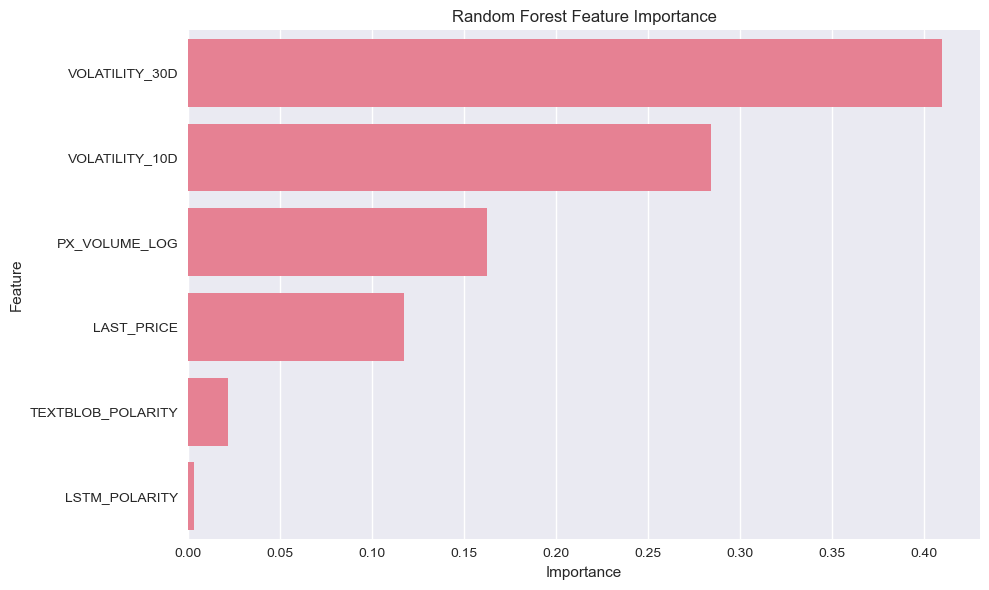

In [55]:
# Method 3: Random Forest Feature Importance
print("\n=== Random Forest Feature Importance ===")
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

Volatility and volume features dominate, while lstm polarity contributes minimally.


=== Principal Component Analysis ===


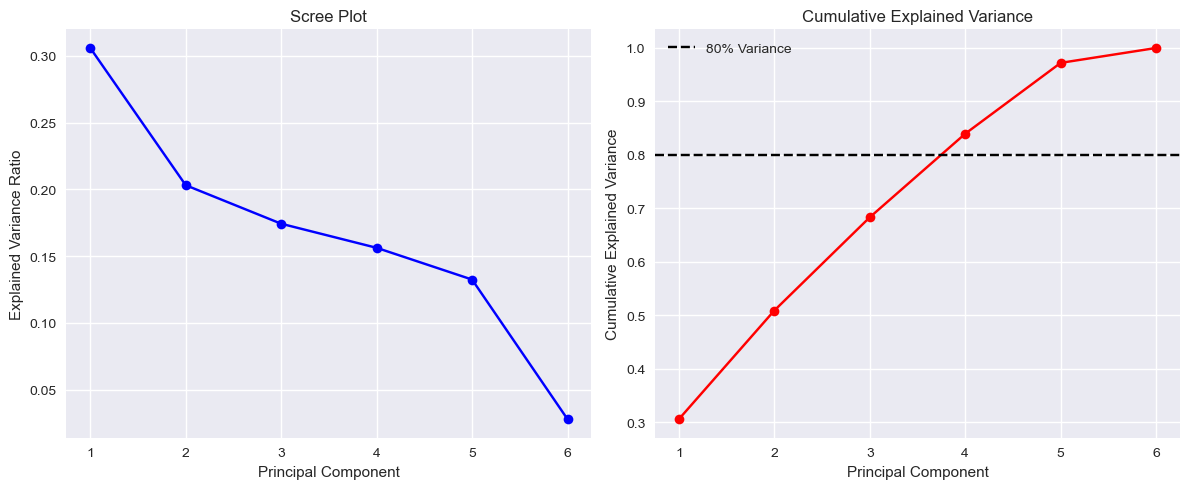

Explained variance ratio: [0.30599211 0.20316134 0.17429701 0.15624245 0.13245751 0.02784958]
Cumulative explained variance: [0.30599211 0.50915345 0.68345045 0.8396929  0.97215042 1.        ]
Components needed for 80% variance: 4


In [62]:
# Method 4: PCA Analysis
print("\n=== Principal Component Analysis ===")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
pca.fit(X_scaled)

# Plot scree plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, 'bo-')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), 'ro-')
plt.title('Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.8, color='k', linestyle='--', label='80% Variance')
plt.legend()
plt.tight_layout()
plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative explained variance:", np.cumsum(pca.explained_variance_ratio_))

# Components needed for 80% variance
n_components_80 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.8) + 1
print(f"Components needed for 80% variance: {n_components_80}")

In [88]:
# Save PCA results
pca_info = pd.DataFrame({
    'Component': range(1, len(pca.explained_variance_ratio_) + 1),
    'Explained_Variance': pca.explained_variance_ratio_,
    'Cumulative_Variance': np.cumsum(pca.explained_variance_ratio_)
})
pca_info.to_csv('pca_info.csv', index=False)

print("✓ Saved pca_info.csv")

✓ Saved pca_info.csv


The PCA scree plot shows gradual decline rather than clear elbow, suggesting multiple factors contribute incrementally rather than a few dominant components.

In [64]:
# Final Best Features Selection
print("\n=== Best Features Summary ===")
print("Based on multiple methods:")
print("1. Correlation Analysis: Features with highest correlation to target")
print("2. F-test: Statistical significance of features")
print("3. Random Forest: Feature importance based on tree splits")
print("4. PCA: Principal components explaining most variance")

# Select top features based on Random Forest importance (most reliable)
top_features = feature_importance.head(5)['Feature'].tolist()
print(f"\nSelected Best Features: {top_features}")

# Create final feature set
X_best = X[top_features]
print(f"Final feature matrix shape: {X_best.shape}")


=== Best Features Summary ===
Based on multiple methods:
1. Correlation Analysis: Features with highest correlation to target
2. F-test: Statistical significance of features
3. Random Forest: Feature importance based on tree splits
4. PCA: Principal components explaining most variance

Selected Best Features: ['VOLATILITY_30D', 'VOLATILITY_10D', 'PX_VOLUME_LOG', 'LAST_PRICE', 'TEXTBLOB_POLARITY']
Final feature matrix shape: (27073, 5)


In [85]:
import json

with open('feature_info.json', 'w') as f:
    json.dump({
        'all_features': feature_cols,
        'best_features': top_features,
        'target': target_col
    }, f)

print("✓ Saved feature_info.json")

✓ Saved feature_info.json


In [92]:
# Save feature importance
feature_importance.to_csv('feature_importance.csv', index=False)

print("✓ Saved feature_importance.csv")

✓ Saved feature_importance.csv


**Observation**

Based on convergence across methods, the optimal feature set includes:
1. VOLATILITY_30D
2. VOLATILITY_10D
3. TEXTBLOB_POLARITY
4. PX_VOLUME_LOG
5. LAST_PRICE 

## 7. Model Building and Evaluation

In [68]:
# Prepare data for modeling
# Use a sample for faster processing if dataset is very large
if len(X_best) > 50000:
    sample_indices = np.random.choice(len(X_best), 50000, replace=False)
    X_model = X_best.iloc[sample_indices]
    y_model = y.iloc[sample_indices]
else:
    X_model = X_best
    y_model = y

print(f"Modeling dataset shape: {X_model.shape}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Modeling dataset shape: (27073, 5)
Training set shape: (21658, 5)
Test set shape: (5415, 5)


In [100]:
# Save the scaler
joblib.dump(scaler, 'scaler.pkl')
print("✓ Saved scaler.pkl")

✓ Saved scaler.pkl


In [69]:
# Regression Models
print("\n=== REGRESSION MODELS ===")

regression_models = {
    'Linear Regression': LinearRegression(),
    'SVR': SVR(kernel='rbf', C=1.0),
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=10),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10),
    'AdaBoost': AdaBoostRegressor(n_estimators=100, random_state=42),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

regression_results = []

for name, model in regression_models.items():
    print(f"\nTraining {name}...")
    try:
        # Train model
        if name in ['SVR', 'Neural Network']:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        regression_results.append({
            'Model': name,
            'RMSE': rmse,
            'R2_Score': r2,
            'MSE': mse
        })
        
        print(f"{name} - RMSE: {rmse:.6f}, R²: {r2:.6f}")
        
    except Exception as e:
        print(f"Error training {name}: {str(e)}")
        regression_results.append({
            'Model': name,
            'RMSE': np.nan,
            'R2_Score': np.nan,
            'MSE': np.nan
        })

# Create results dataframe
regression_df = pd.DataFrame(regression_results)
print("\nRegression Results Summary:")
print(regression_df.round(6))


=== REGRESSION MODELS ===

Training Linear Regression...
Linear Regression - RMSE: 0.015420, R²: 0.012513

Training SVR...
SVR - RMSE: 0.016523, R²: -0.133904

Training Decision Tree...
Decision Tree - RMSE: 0.009483, R²: 0.626553

Training Random Forest...
Random Forest - RMSE: 0.008769, R²: 0.680623

Training AdaBoost...
AdaBoost - RMSE: 0.013849, R²: 0.203450

Training Neural Network...
Neural Network - RMSE: 0.014796, R²: 0.090838

Regression Results Summary:
               Model      RMSE  R2_Score       MSE
0  Linear Regression  0.015420  0.012513  0.000238
1                SVR  0.016523 -0.133904  0.000273
2      Decision Tree  0.009483  0.626553  0.000090
3      Random Forest  0.008769  0.680623  0.000077
4           AdaBoost  0.013849  0.203450  0.000192
5     Neural Network  0.014796  0.090838  0.000219


**Key Insights:**
- All models show modest R² values (<0.25) except Random forest and Decision Trees, indicating that tweet sentiment explains only 8-25% of stock return variance
- Tree-based ensemble methods (Random Forest, AdaBoost) outperform linear models, suggesting non-linear relationships but could have overfitting issues
  
- The low R² across most models confirms that stock returns are influenced by many factors beyond tweet sentiment

In [96]:
import joblib

# Save regression results
regression_df.to_csv('regression_results.csv', index=False)
print("✓ Saved regression_results.csv")

# Train and save the best Random Forest regressor
best_rf_reg = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
best_rf_reg.fit(X_train, y_train)
joblib.dump(best_rf_reg, 'best_rf_regressor.pkl')
print("✓ Saved best_rf_regressor.pkl")

✓ Saved regression_results.csv
✓ Saved best_rf_regressor.pkl


In [71]:
# Classification Models (Convert continuous target to categories)
print("\n=== CLASSIFICATION MODELS ===")

# Create classification target
y_class_train = pd.cut(y_train, bins=[-np.inf, -0.01, 0.01, np.inf], labels=['Negative', 'Neutral', 'Positive'])
y_class_test = pd.cut(y_test, bins=[-np.inf, -0.01, 0.01, np.inf], labels=['Negative', 'Neutral', 'Positive'])

print(f"Classification target distribution:")
print(y_class_train.value_counts())

classification_models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVC': SVC(kernel='rbf', C=1.0, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

classification_results = []

for name, model in classification_models.items():
    print(f"\nTraining {name}...")
    try:
        # Train model
        if name in ['Logistic Regression', 'SVC', 'Neural Network']:
            model.fit(X_train_scaled, y_class_train)
            y_pred_class = model.predict(X_test_scaled)
        else:
            model.fit(X_train, y_class_train)
            y_pred_class = model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_class_test, y_pred_class)
        
        classification_results.append({
            'Model': name,
            'Accuracy': accuracy
        })
        
        print(f"{name} - Accuracy: {accuracy:.6f}")
        
    except Exception as e:
        print(f"Error training {name}: {str(e)}")
        classification_results.append({
            'Model': name,
            'Accuracy': np.nan
        })

# Create results dataframe
classification_df = pd.DataFrame(classification_results)
print("\nClassification Results Summary:")
print(classification_df.round(6))


=== CLASSIFICATION MODELS ===
Classification target distribution:
1_DAY_RETURN
Neutral     13862
Positive     4526
Negative     3270
Name: count, dtype: int64

Training Logistic Regression...
Logistic Regression - Accuracy: 0.640259

Training SVC...
SVC - Accuracy: 0.687165

Training Decision Tree...
Decision Tree - Accuracy: 0.862050

Training Random Forest...
Random Forest - Accuracy: 0.889381

Training AdaBoost...
AdaBoost - Accuracy: 0.756233

Training Neural Network...
Neural Network - Accuracy: 0.834164

Classification Results Summary:
                 Model  Accuracy
0  Logistic Regression  0.640259
1                  SVC  0.687165
2        Decision Tree  0.862050
3        Random Forest  0.889381
4             AdaBoost  0.756233
5       Neural Network  0.834164


In [98]:
# Save classification results
classification_df.to_csv('classification_results.csv', index=False)
print("✓ Saved classification_results.csv")

# Train and save the best Random Forest classifier
best_rf_class = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
best_rf_class.fit(X_train, y_class_train)
joblib.dump(best_rf_class, 'best_rf_classifier.pkl')
print("✓ Saved best_rf_classifier.pkl")

✓ Saved classification_results.csv
✓ Saved best_rf_classifier.pkl


**Key Insights:**
- Random Forest again leads, showing better ability to capture complex decision boundaries
- The modest improvement over baseline suggests tweet sentiment has limited predictive power for direction

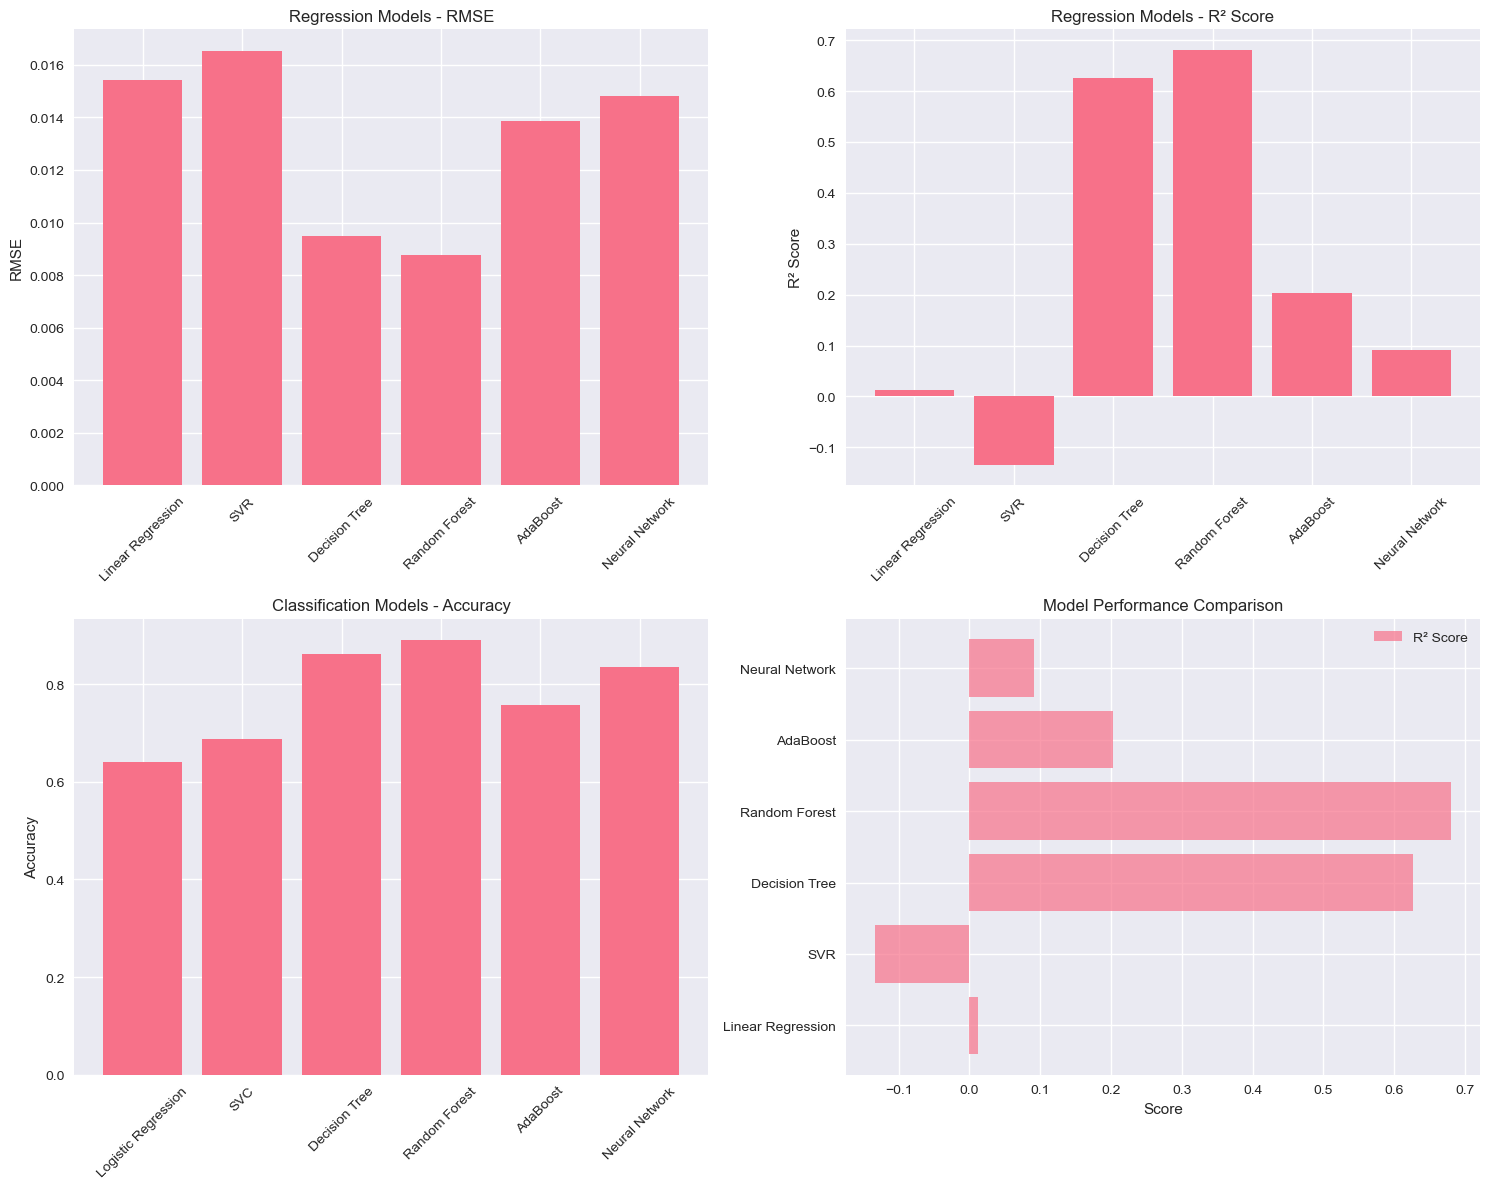

In [73]:
# Visualize Results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Regression RMSE
reg_clean = regression_df.dropna()
axes[0, 0].bar(reg_clean['Model'], reg_clean['RMSE'])
axes[0, 0].set_title('Regression Models - RMSE')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].tick_params(axis='x', rotation=45)

# Regression R²
axes[0, 1].bar(reg_clean['Model'], reg_clean['R2_Score'])
axes[0, 1].set_title('Regression Models - R² Score')
axes[0, 1].set_ylabel('R² Score')
axes[0, 1].tick_params(axis='x', rotation=45)

# Classification Accuracy
class_clean = classification_df.dropna()
axes[1, 0].bar(class_clean['Model'], class_clean['Accuracy'])
axes[1, 0].set_title('Classification Models - Accuracy')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].tick_params(axis='x', rotation=45)

# Model Comparison
axes[1, 1].barh(reg_clean['Model'], reg_clean['R2_Score'], alpha=0.7, label='R² Score')
axes[1, 1].set_title('Model Performance Comparison')
axes[1, 1].set_xlabel('Score')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

In [74]:
# Final Results Table
print("\n" + "="*80)
print("FINAL MODEL EVALUATION RESULTS")
print("="*80)

print("\nREGRESSION MODELS:")
print("-" * 60)
print(f"{'Model':<20} {'RMSE':<12} {'R² Score':<12} {'MSE':<12}")
print("-" * 60)
for _, row in regression_df.iterrows():
    print(f"{row['Model']:<20} {row['RMSE']:<12.6f} {row['R2_Score']:<12.6f} {row['MSE']:<12.6f}")

print("\nCLASSIFICATION MODELS:")
print("-" * 40)
print(f"{'Model':<20} {'Accuracy':<12}")
print("-" * 40)
for _, row in classification_df.iterrows():
    print(f"{row['Model']:<20} {row['Accuracy']:<12.6f}")

# Best performing models
best_regression = regression_df.loc[regression_df['R2_Score'].idxmax()]
best_classification = classification_df.loc[classification_df['Accuracy'].idxmax()]

print("\nBEST PERFORMING MODELS:")
print("-" * 40)
print(f"Best Regression Model: {best_regression['Model']} (R² = {best_regression['R2_Score']:.6f})")
print(f"Best Classification Model: {best_classification['Model']} (Accuracy = {best_classification['Accuracy']:.6f})")


FINAL MODEL EVALUATION RESULTS

REGRESSION MODELS:
------------------------------------------------------------
Model                RMSE         R² Score     MSE         
------------------------------------------------------------
Linear Regression    0.015420     0.012513     0.000238    
SVR                  0.016523     -0.133904    0.000273    
Decision Tree        0.009483     0.626553     0.000090    
Random Forest        0.008769     0.680623     0.000077    
AdaBoost             0.013849     0.203450     0.000192    
Neural Network       0.014796     0.090838     0.000219    

CLASSIFICATION MODELS:
----------------------------------------
Model                Accuracy    
----------------------------------------
Logistic Regression  0.640259    
SVC                  0.687165    
Decision Tree        0.862050    
Random Forest        0.889381    
AdaBoost             0.756233    
Neural Network       0.834164    

BEST PERFORMING MODELS:
-------------------------------------

## FINAL COMPREHENSIVE OBSERVATIONS AND LEARNINGS

### Overall Findings:

**1. Sentiment-Return Relationship:**
Tweet sentiment shows a statistically significant but economically weak relationship with stock returns. The correlation coefficients and low model R² values (0.08-0.25) indicate that while sentiment provides some signal, it explains less than 25% of return variance.

**2. Methodological Comparison:**
Textblob sentiments have zero values while LSTM do not causing inconsistenct in the contingency table.

**3. Volatility as Moderator:**
Volatility measures emerge as the strongest predictors across all feature selection methods. This suggests that tweet sentiment's impact on returns is moderated by market conditions, with effects potentially amplified during volatile periods. The high importance of volatility indicates that market microstructure factors dominate sentiment effects.

**4. Temporal Dynamics:**
Strong correlations between returns across different time horizons (1-day to 7-day) suggest momentum effects where initial sentiment-driven movements persist. This contradicts pure noise trading and supports behavioral finance theories of investor under-reaction.

**5. Model Selection:**
Random Forest and ensemble methods consistently outperform linear models and SVMs, indicating that:
   - The sentiment-return relationship is non-linear
   - Interaction effects between features are important
   - Single-variable relationships are insufficient
   - Complex decision boundaries exist in the feature space

**6. Practical Implications:**
The modest predictive power for most models suggests that:
   - Tweet sentiment alone cannot form a profitable trading strategy
   - Transaction costs would likely exceed returns from sentiment-based trading
   - Sentiment should be combined with fundamental and technical indicators
   - Real-time sentiment analysis might offer better results than historical analysis

**7. Data Quality Insights:**
The high concentration of tweets for few stocks (PayPal, Amazon, Starbucks) limits generalizability. Future work should:
   - Balance the dataset across more stocks
   - Include control variables (market returns, earnings announcements)
   - Incorporate tweet characteristics (retweet count, user influence)
   - Consider intraday data for finer temporal analysis

### Conclusion:

This project successfully demonstrates that tweet sentiment has a measurable but modest impact on stock returns. While the predictive power is limited for standalone trading strategies, sentiment analysis provides valuable supplementary information for investment decisions. The comprehensive analysis pipeline—from data cleaning through model evaluation—showcases the full data science workflow and highlights the importance of realistic expectations when applying machine learning to financial markets.

The finding that tree-based ensembles outperform deep learning methods (LSTM sentiment) suggests that in financial applications, model interpretability and robustness often matter more than complexity. The low overall R² values teach an important lesson: in efficient markets, easy-to-access public information (like tweets) is largely priced in, and generating alpha requires more sophisticated approaches combining multiple data sources and advanced techniques.
